Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :) 📓 This repository/notebook serves as a personal reminder for me, documenting code snippets and techniques sourced from various learning resources. The goal is to consolidate valuable information and create a basic reference guide. Please note that the codes included here are not originally mine, and credit goes to the respective authors and resources. Feel free to explore and use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter11
    
#### Purpose :
    * Effect of Latent Size in Autoencoder 
    
#### Keywords :
    * Latent Size
    * Autoencoder

 At first , we build an autoencoder and train it with mnist dataset. The latent size will be 3 and we will visualize the model prediction

In [1]:

from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [3]:
trn_ds = MNIST('./MNIST/', transform=img_transform, train=True, download=True)
val_ds = MNIST('./MNIST/', transform=img_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:02<00:00, 4103869.53it/s]


Extracting ./MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14357673.80it/s]


Extracting ./MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4020109.81it/s]


Extracting ./MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw



In [4]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [10]:

from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, (1,28,28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
            Linear-6                   [-1, 64]             256
              ReLU-7                   [-1, 64]               0
            Linear-8                  [-1, 128]           8,320
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 784]         101,136
             Tanh-11                  [-1, 784]               0
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [11]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  val_loss: 0.193  trn_loss: 0.257  (19.92s - 79.66s remaining)
EPOCH: 2.000  val_loss: 0.166  trn_loss: 0.178  (39.92s - 59.87s remaining)
EPOCH: 3.000  val_loss: 0.156  trn_loss: 0.161  (59.40s - 39.60s remaining)
EPOCH: 4.000  val_loss: 0.152  trn_loss: 0.154  (79.93s - 19.98s remaining)
EPOCH: 5.000  val_loss: 0.148  trn_loss: 0.150  (100.18s - 0.00s remaining)


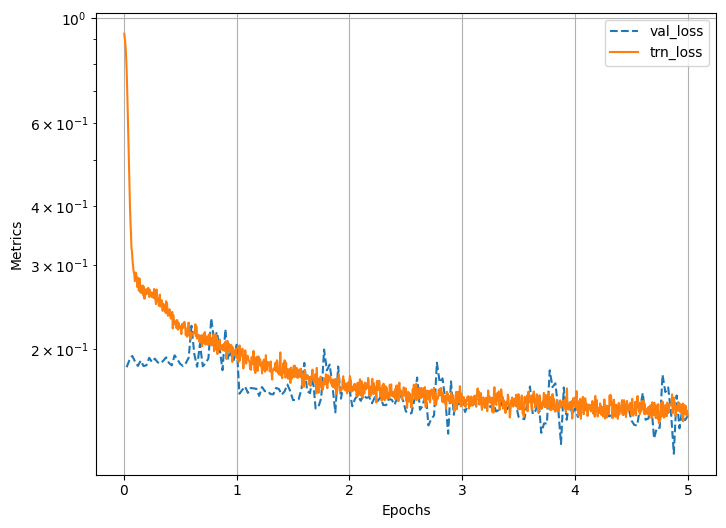

In [12]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

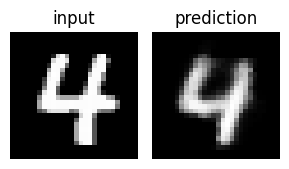

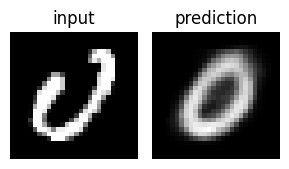

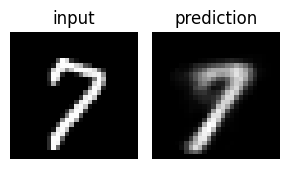

In [13]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

To understand the effect of latent size, we will build same autoencoder model with different bottleneck size. We will train them same number of epochs and visualize the results.

EPOCH: 1.000  val_loss: 0.139  trn_loss: 0.236  (20.36s - 81.42s remaining)
EPOCH: 2.000  val_loss: 0.097  trn_loss: 0.114  (40.96s - 61.44s remaining)
EPOCH: 3.000  val_loss: 0.082  trn_loss: 0.090  (61.86s - 41.24s remaining)
EPOCH: 4.000  val_loss: 0.073  trn_loss: 0.079  (82.21s - 20.55s remaining)
EPOCH: 5.000  val_loss: 0.066  trn_loss: 0.071  (102.92s - 0.00s remaining)


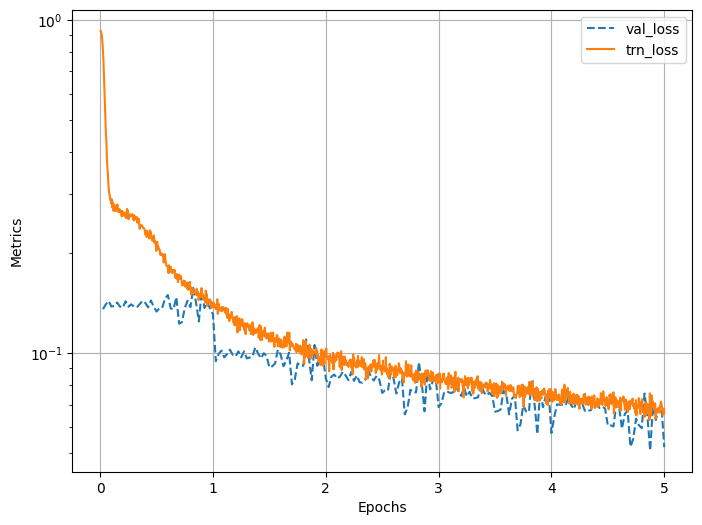

EPOCH: 1.000  val_loss: 0.206  trn_loss: 0.263  (19.45s - 77.80s remaining)
EPOCH: 2.000  val_loss: 0.187  trn_loss: 0.196  (39.25s - 58.87s remaining)
EPOCH: 3.000  val_loss: 0.179  trn_loss: 0.183  (59.41s - 39.61s remaining)
EPOCH: 4.000  val_loss: 0.174  trn_loss: 0.177  (80.08s - 20.02s remaining)
EPOCH: 5.000  val_loss: 0.170  trn_loss: 0.172  (99.58s - 0.00s remaining)


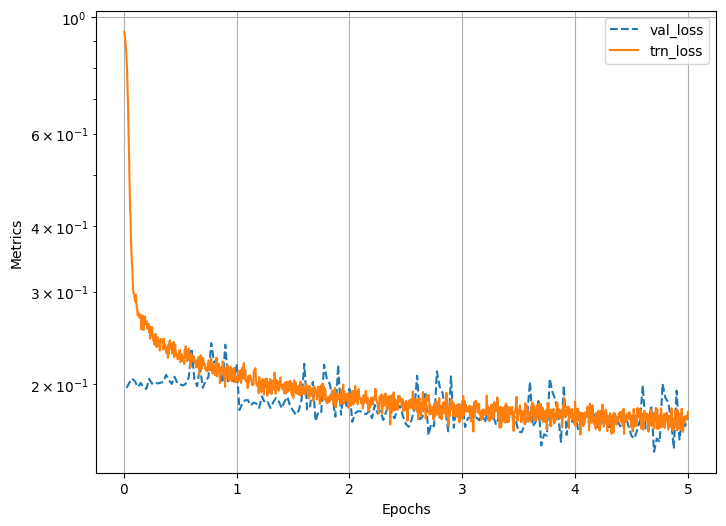

EPOCH: 1.000  val_loss: 0.194  trn_loss: 0.259  (19.95s - 79.78s remaining)
EPOCH: 2.000  val_loss: 0.168  trn_loss: 0.180  (40.02s - 60.03s remaining)
EPOCH: 3.000  val_loss: 0.158  trn_loss: 0.162  (60.05s - 40.03s remaining)
EPOCH: 4.000  val_loss: 0.152  trn_loss: 0.154  (79.30s - 19.83s remaining)
EPOCH: 5.000  val_loss: 0.148  trn_loss: 0.150  (99.79s - 0.00s remaining)


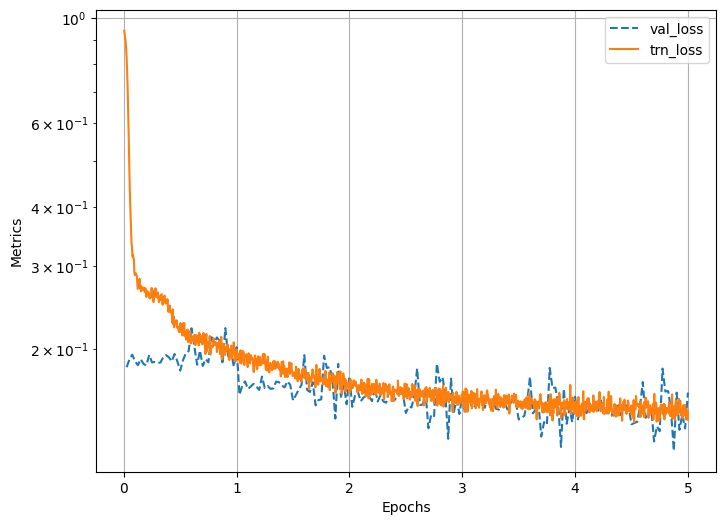

EPOCH: 1.000  val_loss: 0.165  trn_loss: 0.248  (19.59s - 78.35s remaining)
EPOCH: 2.000  val_loss: 0.139  trn_loss: 0.150  (39.38s - 59.07s remaining)
EPOCH: 3.000  val_loss: 0.129  trn_loss: 0.134  (61.80s - 41.20s remaining)
EPOCH: 4.000  val_loss: 0.123  trn_loss: 0.126  (83.96s - 20.99s remaining)
EPOCH: 5.000  val_loss: 0.120  trn_loss: 0.122  (104.81s - 0.00s remaining)


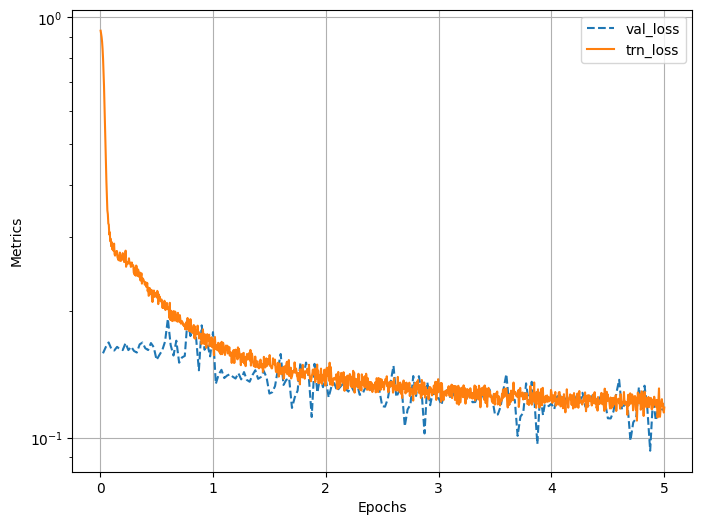

EPOCH: 1.000  val_loss: 0.158  trn_loss: 0.252  (19.94s - 79.75s remaining)
EPOCH: 2.000  val_loss: 0.117  trn_loss: 0.135  (39.88s - 59.82s remaining)
EPOCH: 3.000  val_loss: 0.105  trn_loss: 0.112  (59.56s - 39.71s remaining)
EPOCH: 4.000  val_loss: 0.098  trn_loss: 0.103  (80.60s - 20.15s remaining)
EPOCH: 5.000  val_loss: 0.093  trn_loss: 0.097  (100.79s - 0.00s remaining)


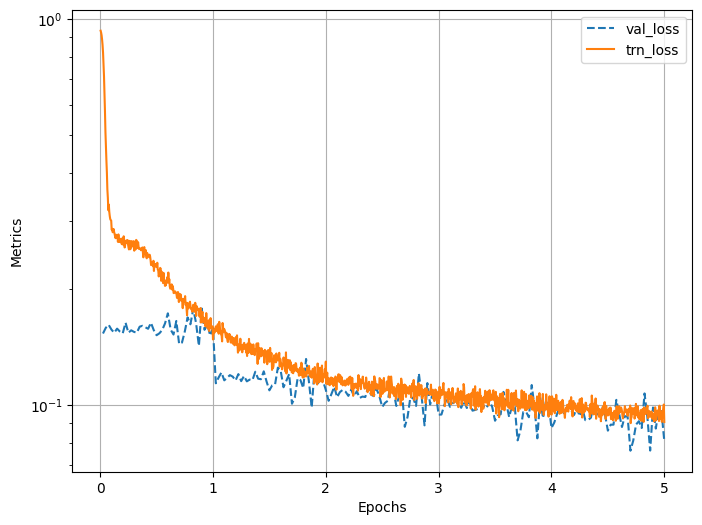

In [14]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    save_path = 'mymodel_simple_autoencoder_{}.pth'.format(latent_dim)
    torch.save(model.state_dict(), save_path)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

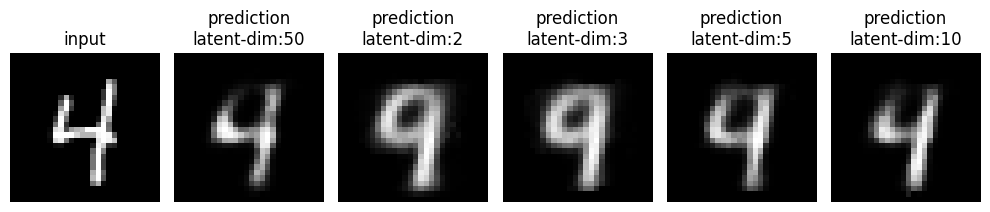

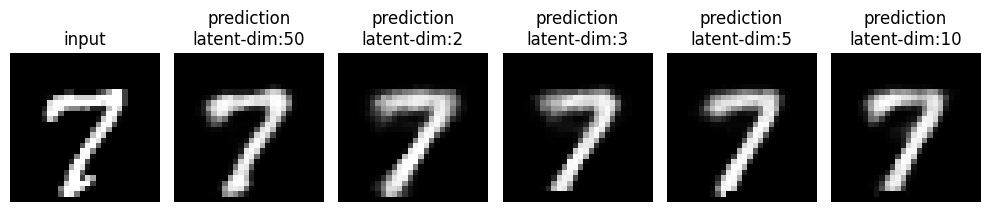

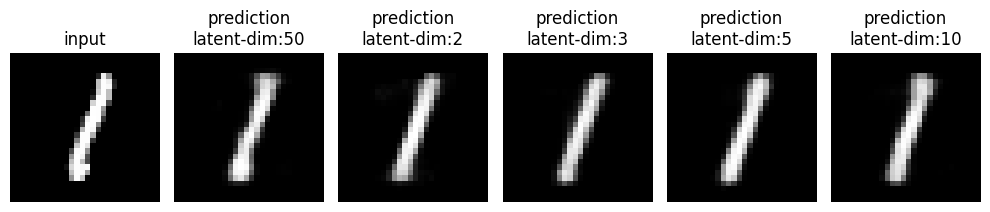

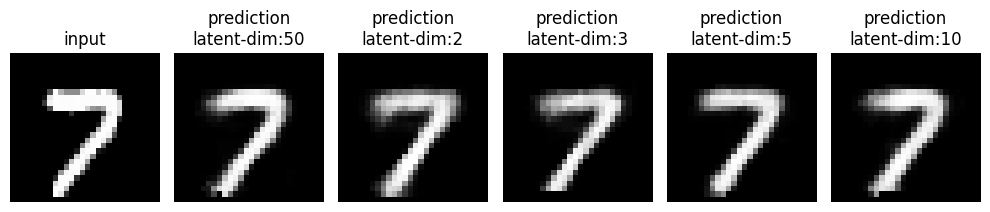

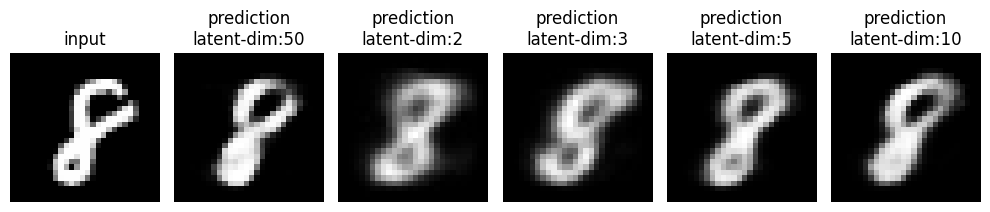

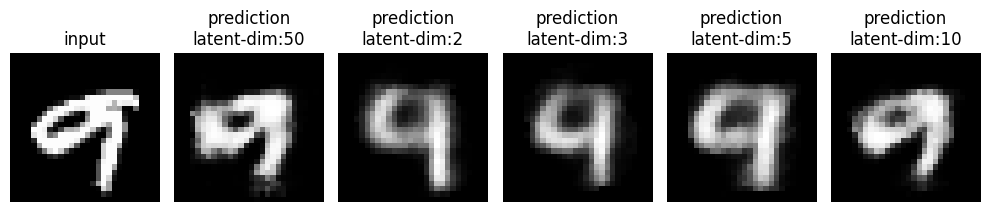

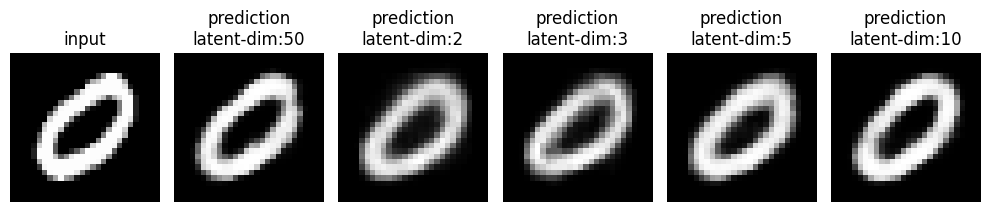

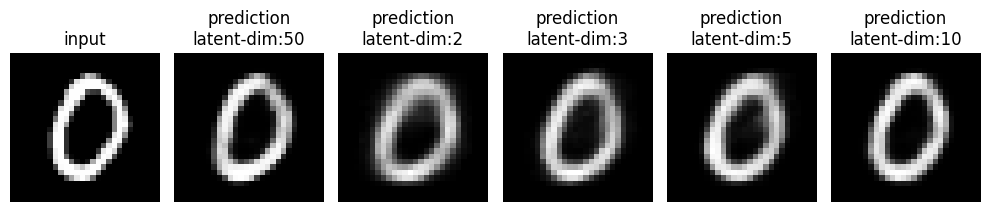

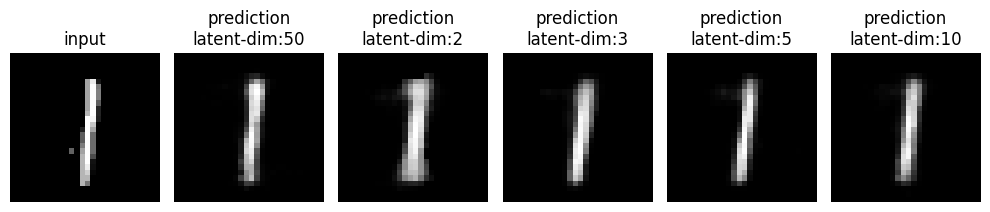

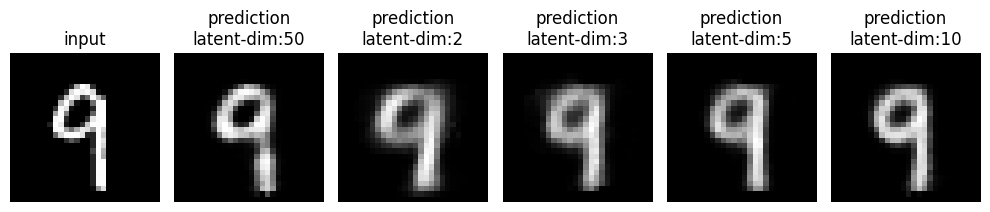

In [15]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()